# Introduction

The goal of this notebook is to use data to understand the relationship that pressure and temperature play in engine failure.  Regression is often a great statistical tool to help understand relationships between data, however, the type of regression one choses to use depends on several factors.  Most of the time, one needs to visualize the data before any decision about what kind of regression would be most appropriate to use.  For reasons that will be made clear shortly, this notebook will focus specifically on logistic regression. 

First, let's import the necessary modules and then read in the data.

## Imports 

In [1]:
# For manipulating data
import pandas as pd

# For plotting graphs
import matplotlib.pyplot as plt

# For constructing the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# For evaluating model performance
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read Data

In [2]:
# Load the data set.  Use the CSV's first column as the dataframe's index
df = pd.read_csv("../data/toy_data.csv", index_col=0)

# Check data loaded correctly
df.head()

,pressure (psi),temperature (deg F),failure
0,15.02,192.80,no
1,15.34,199.77,no
2,15.09,197.31,no
3,14.22,199.04,no
4,14.24,205.32,no


In [3]:
# Store label names for x and y
x_label = 'pressure (psi)'
y_label = 'temperature (deg F)'

# Store target label name
target_label = 'failure'

## Visualize The dataset

In [4]:
# Assign colors based on target_label for visualization
df['color'] = df[target_label].map({'no':'green', 'yes':'red'})

# Seperate the data on engines that failed
# from those that didn't
df_yesses = df[df[target_label]=='yes']
df_nos = df[df[target_label]=='no']

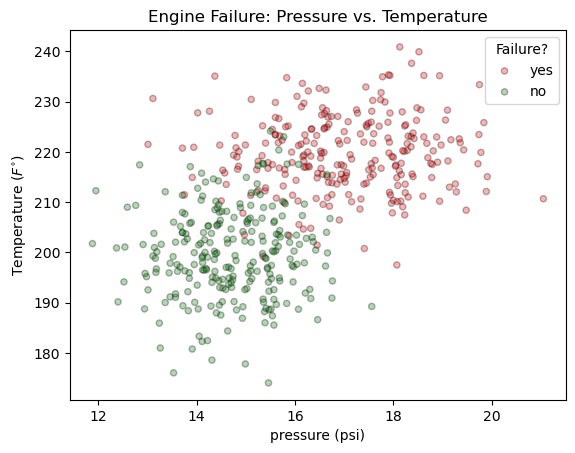

In [5]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Scatter plot of engine data that failed 
ax.scatter(x=df_yesses[x_label], 
           y=df_yesses[y_label],
           c=df_yesses['color'],
           label='yes', s=20, 
           edgecolor="k", alpha=0.3)

# Scatter plot of engine data that didn't fail
ax.scatter(df_nos[x_label], df_nos[y_label], c=df_nos['color'], s=20, edgecolor="k", label='no', alpha=0.3)

ax.set_title('Engine Failure: Pressure vs. Temperature')
ax.set_xlabel(x_label)
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

plt.show()

It looks like higher pressure and/or higher temperature is when most engines in the dataset fail.  Using logistic regression, it may be possible to understand the limits of these engines and what range of operating pressures or temperatures are best suited to keep them running.

# Why Logistic Regression

Logistic regression is able to use any number of qualitative or quantitative inputs to predict a qualitative output.  **It can only predict a qualitative output**.  Because our goal is to predict whether an engine failed or not, which is qualitative, logistic regression can be used.

**Note**: Using qualitative inputs involves a little more effort than quantitative inputs, as does trying to predict a non-binary qualitative output.  This notebook will first consider the simplest case of logistic regression, when only quantitative inputs are used (engine pressure and temperature) and when the output is binary (the engine either failed or it didn't).  However, sections will be added to the notebook later to discuss how to deal with these situations.

# Generate Training and Testing Data

While not true in all circumstances, the goal of many ML algorithms is to use the algorithm on new and unseen data at some point.  For this reason, it's important to test the algorithm on unseen data in order to verify its performance and whether or not it will be worthwhile to use.  

This leaves two options:
* Option 1: Build the model now and wait for a sufficient amount of new data to come in, which can be used to verify the model's accuracy.
* Option 2: Parition the dataset into a training set and a testing set.  The training set can be used to build the model and the testing set will only be used to verify the accuracy.

Some may be concerned that by partioning your dataset and then only using part of it to build the model might negatively affect its performance.  After all, it's reasonable to think that the more data points you have the better off it will be, yet there tend to be diminishing returns.  As it turns out, as long as your dataset is sufficiently large, performing a train/test split will still yield quite good results.  Given the alternative is waiting, a train/test split approach is preferred because it will allow you to determine performance immmediately and tweaks to the model can be implemented quickly, if need be.

In [6]:
# Separate feature names
feat_names = [x_label, y_label]

# Extract unique class labels
unique_labels = df[target_label].unique()

In [7]:
# Split dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df[feat_names],
                                                    df[target_label],
                                                    test_size=0.25,
                                                    random_state=42)

# Training the Logistic Regression Model

In [8]:
# Create logistic regression object
log_reg_classifier = LogisticRegression(random_state=0)

# Train the model using the training dataset
log_reg_classifier = log_reg_classifier.fit(X_train, y_train)

# Evaluating model performance - testing data

## Making Predictions

Now that the model has been trained, it can be used to make predictions.  Logistic regression works by taking all inputs to the model and calculating a probability of a binary output.  When the predicted probability is >50%, the model predicts the class label of 1 (engine failure) for that observation, otherwise it predicts a class label of 0 (engine didn't fail).

In [9]:
# Make predictions using the already seen training data
predictions = log_reg_classifier.predict(X_test)
probabilities = log_reg_classifier.predict_proba(X_test)

results_df = pd.DataFrame({x_label:X_test[x_label],
                           y_label:X_test[y_label],
                         #'prob of no':probabilities[:,0],
                         'prob of fail':probabilities[:,1],
                         'predicted failure':predictions,
                         'actual failure': y_test})
results_df.head()

,pressure (psi),temperature (deg F),prob of fail,predicted failure,actual failure
361,17.93,235.23,0.999950,yes,yes
73,14.03,188.73,0.000235,no,no
374,15.93,219.96,0.947080,yes,yes
155,14.94,204.14,0.054796,no,no
104,11.95,212.28,0.007696,no,no


The results_df shows the logistic regression model's probablility of failure based on pressure (psi) and temperature $(F^{\circ})$.  For instance, the first row shows when pressure = 17.93 and temperature = 235.23, the model assigns a probability of failure of 0.999950.  That probability is >50% and therefore the observation is labeled as 1 (engine failed).  

All 5 entries in the results_df have the predicted failure value match the actual failure value, meaning all 5 predictions on these observations were correct, but how's the accuracy for the rest of the dataset?

## Checking Accuracy

In [10]:
accuracy = log_reg_classifier.score(X_test, y_test)
accuracy

0.912

The model has high accuracy on testing data, correctly predicting when an engine will fail 91.2% of the time.  The model appears to do well on unseen data, giving confidence that it generalizes well.

## Visualizing Decision Boundaries

In [11]:
# Create copy of X_test data
X_test_copy = X_test.copy(deep=True)

# Assign failure labels
X_test_copy[target_label] = y_test

# Assign colors
colors = []
for y in y_test:
    if y == 'yes':
        colors.append('red')
    else:
        colors.append('green')
X_test_copy['color'] = colors

# Separate failured engines from non-failured engines for plotting  
test_yesses = X_test_copy[X_test_copy[target_label]=='yes']
test_nos = X_test_copy[X_test_copy[target_label]=='no']

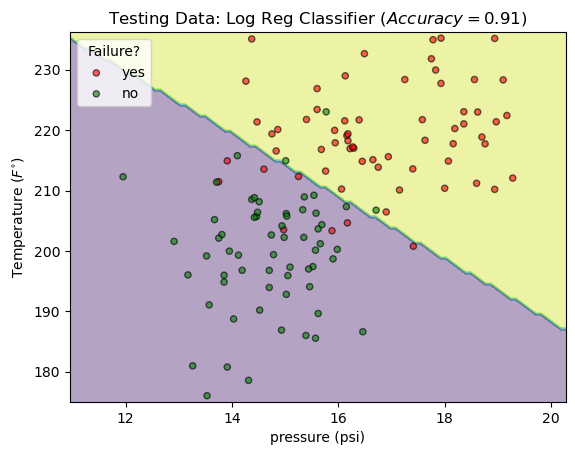

In [12]:
# Create figure and axis for graphing
fig, ax = plt.subplots(1,1)

# Draw the model's decision boundary, a boundary separating
# where it predicts a failure from a non-failure
DecisionBoundaryDisplay.from_estimator(estimator=log_reg_classifier, 
                                       X=X_test, 
                                       alpha=0.4, 
                                       response_method="predict", 
                                       ax=ax)

# Scatter plot of engine data that failed 
ax.scatter(x=test_yesses[x_label], 
           y=test_yesses[y_label], 
           c=test_yesses['color'], 
           s=20, edgecolor="k", label='yes', alpha=0.6)

# Scatter plot of engine data that didn't fail
ax.scatter(x=test_nos[x_label],
           y=test_nos[y_label],
           c=test_nos['color'], 
           s=20, edgecolor="k", label='no', alpha=0.6)

ax.set_title(f'Testing Data: Log Reg Classifier $(Accuracy = {accuracy:.2f})$')
ax.set_ylabel(r'Temperature ($F^{\circ}$)')
ax.legend(title='Failure?')

#plt.tight_layout()
plt.show()

## Confusion Matrix

A confusion matrix helps get a slightly better picture of the model's predictive accuracy.  It enables one to see how many correct and incorrect predictions occurred for the binary output.

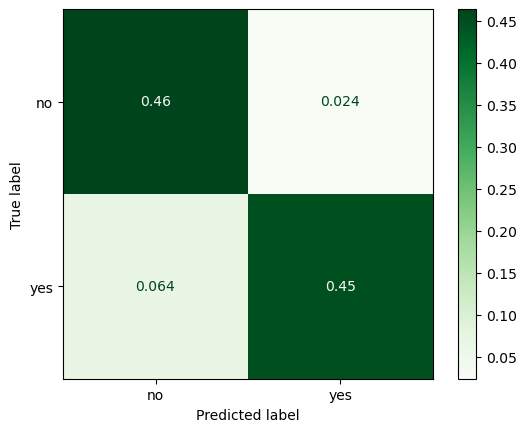

In [13]:
# Create confusion matrix object
cm = confusion_matrix(y_true=y_test, 
                      y_pred=predictions,
                      labels=unique_labels,
                      normalize='all')

# Create confusion matrix display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=unique_labels)

# Graph confusion matrix display
cm_display.plot(cmap='Greens')

plt.show()

The confusion matrix shows the model correctly predictes engine failure 45% of the time and predicts when an engine won't fail 46% of the time.  The model incorrect predicts an engine won't fail 6.4% of the time and incorrectly predicts an engine will fail 2.4% of the time.

# Conclusion

By visualizing the dataset, it was clear that some kind of relationship existing between the pressure and temperature of an engine and whether or not it would fail.  Logistic regression was able to pick up on this relationship and performed reasonably well on testing data, with an overall predictive accuracy of 91.2%.